In [1]:
from nilearn import image, datasets, input_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Choice of subject:
subj_nb = 6

In [3]:
# Loading an fMRI file
fmri_file_path_run1 = f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{subj_nb}/func/sub-0{subj_nb}_task-carrsq_run-1_bold.nii.gz'
fmri_file_path_run2 = f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{subj_nb}/func/sub-0{subj_nb}_task-carrsq_run-2_bold.nii.gz'


In [4]:
# Load a brain atlas to define regions of interest (ROI)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# Initializing a signal extractor using the atlas ROI map
masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

# Extraction of average signals for each ROI from the two fMRI runs
time_series_run1 = masker.fit_transform(fmri_file_path_run1)
time_series_run2 = masker.fit_transform(fmri_file_path_run2)

# Combining the time series of the two runs
time_series_combined = np.concatenate([time_series_run1, time_series_run2], axis=0)


c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\nilearn\maskers\nifti_labels_masker.py:625: UserWarning: After resampling the label image to the data image, the following labels were removed: {48}. Label image only contains 48 labels (including background).
  warnings.warn(


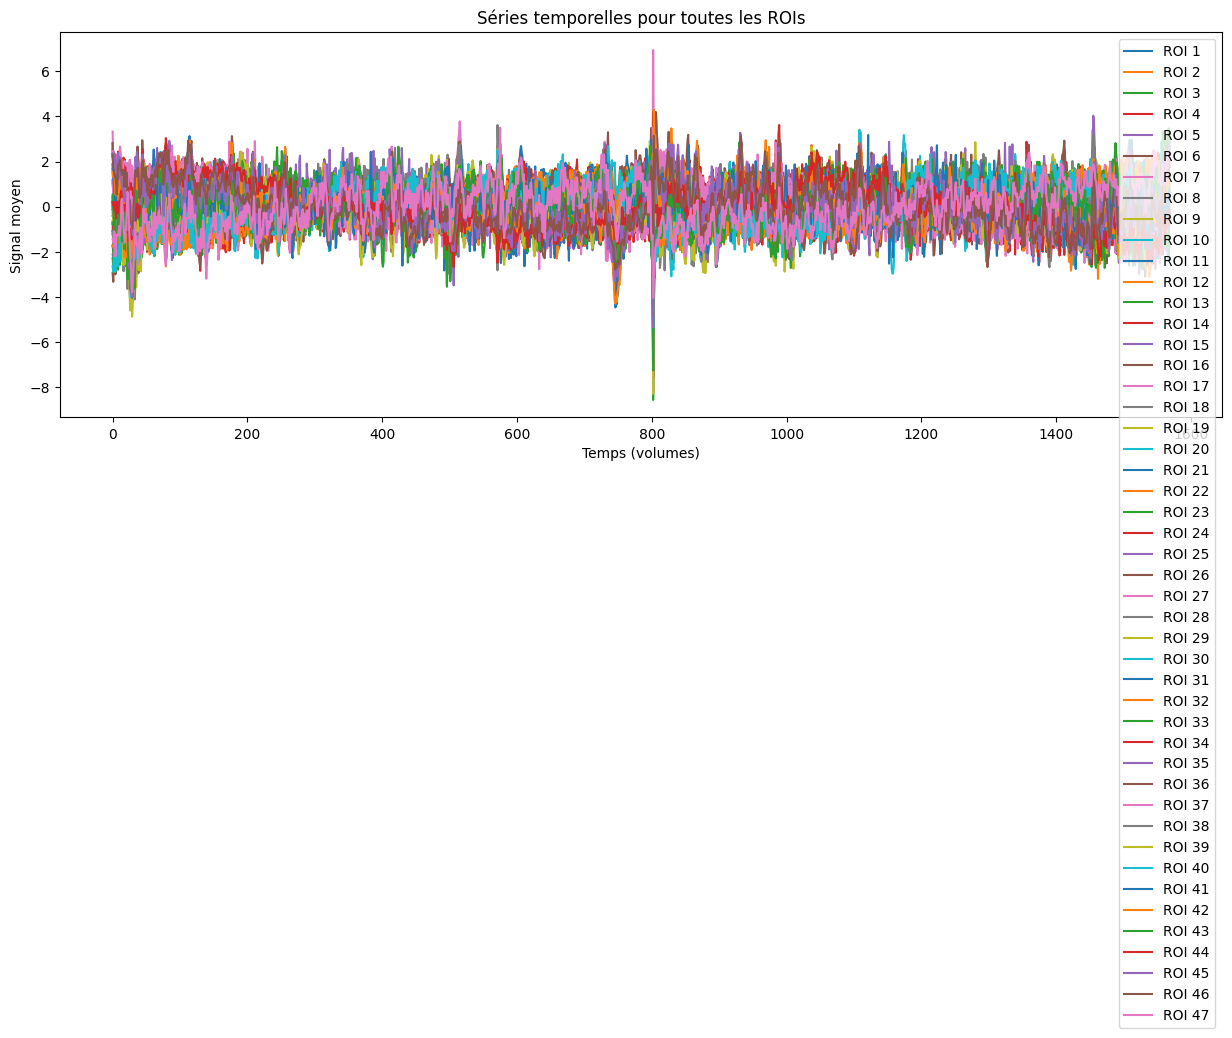

In [5]:
# Plot all time series:
plt.figure(figsize=(15, 5))
for i in range(time_series_combined.shape[1]):  
    plt.plot(time_series_combined[:, i], label=f'ROI {i+1}')
plt.title('Séries temporelles pour toutes les ROIs')
plt.xlabel('Temps (volumes)')
plt.ylabel('Signal moyen')
plt.legend()
plt.show()

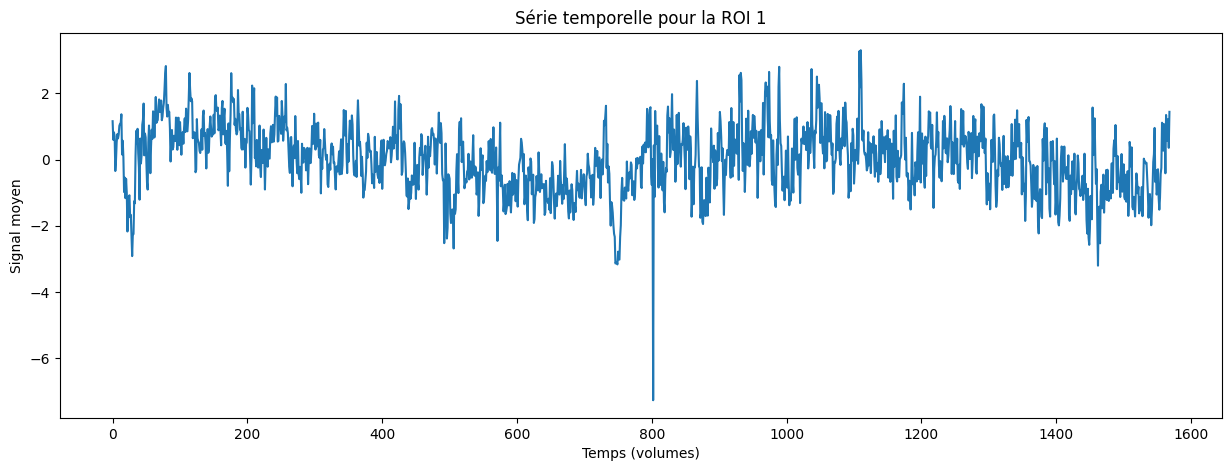

In [6]:
# Plot the time series of a single ROI 
plt.figure(figsize=(15, 5))
plt.plot(time_series_combined[:, 1])  # Change index 0 to another column for another ROI
plt.title('Série temporelle pour la ROI 1')
plt.xlabel('Temps (volumes)')
plt.ylabel('Signal moyen')
plt.show()

In [128]:
# Load events.tsv files
events1 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{subj_nb}/func/sub-0{subj_nb}_task-carrsq_run-1_events.tsv', sep='\t')
events2 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{subj_nb}/func/sub-0{subj_nb}_task-carrsq_run-2_events.tsv', sep='\t')

# Calculate total elapsed time to end of first run
# This is equal to the `onset` of the last event plus its `duration`.
total_time_elapsed = events1['onset'].iloc[-1] + events1['duration'].iloc[-1]

# Add this total elapsed time to the `onset` of the second run
events2['onset'] += total_time_elapsed


# Concatenate files
events_combined = pd.concat([events1, events2], ignore_index=True)
events_combined

,onset,duration,trial_type,nb_images
0,0.00,7.00,control,7
1,7.00,24.67,NonRisk,25
2,31.67,8.00,control,8
3,39.67,13.83,NonRisk,14
4,53.50,8.00,control,8
...,...,...,...,...
169,1495.79,8.00,control,8
170,1503.79,8.10,NonRisk,8
171,1511.89,8.00,control,8
172,1519.89,12.63,NonRisk,13


In [129]:
# Get time_series_combined dimensions
n_timestamps, n_rois = time_series_combined.shape
print(f"Nombre de timestamps: {n_timestamps}, Nombre de ROIs: {n_rois}")

Nombre de timestamps: 1568, Nombre de ROIs: 47


In [130]:
import numpy as np
from scipy.stats import skew
import pywt



TR = 1  # Time rate in seconds
delay_seconds = 6  # Time to see the effect of Risk stimuli
delay_points = delay_seconds / TR  # Number of data points corresponding to the delay

# Initialiser une liste pour stocker les caractéristiques extraites de chaque segment pour chaque ROI
features_per_roi = {roi: [] for roi in range(n_rois)}  # Un dictionnaire pour chaque ROI

# Initialize a list to store the features extracted from each segment for each ROI
labels = []

# Browse each segment to extract features
for _, row in events_combined.iterrows():
    onset_time = row['onset']
    duration = row['duration']
    trial_type = row['trial_type']

    if trial_type == 'Risk':
        adjusted_onset_time = onset_time + delay_seconds
    else:
        adjusted_onset_time = onset_time

    #adjusted_onset_time = onset_time
    start_index = int(adjusted_onset_time / TR)  # Convert onset to data point index
    end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
    
    

    for roi in range(n_rois):
    # Extract segment from time series
        segment = time_series_combined[start_index:end_index,roi]

        # Calculation of wavelet coefficients
        coeffs = pywt.wavedec(segment, 'db1', level=2)
        wavelet_features = [np.mean(coef) for coef in coeffs]  # Average of coefficients at each level
        energy = [np.sum(coef ** 2) for coef in coeffs]  # Energy of the coefficients at each level

        
        # Calculate the desired characteristics for the segment
        segment_features = [
            np.mean(segment),  # Average
            #np.std(segment),   # Standard deviation
            np.min(segment),   # Minimum
            np.max(segment),   # Maximum
            #len(np.where(np.diff(np.sign(segment)))[0]) #zero-crossing
            #segment.max() - segment.min() #peak-to-peak
            #np.sum(segment ** 2), #Energy
            #skew(segment),     #Asymetrie: returns Nan because some segments have a low number of timestamps (<3)
        ] #+ wavelet_features  # Added wavelet features

        features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
    
        # Add segment characteristics and label to lists
    labels.append(row['trial_type'])

# Convert lists to numpy arrays for later analysis
labels = np.array(labels)
df_roi = pd.DataFrame(features_per_roi)

c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [131]:
df_roi

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,"[1.1458492699172402, 0.8035553693307471, 1.779...","[2.1797934815173243, 1.7985296344402575, 2.658...","[1.8524841160476864, 1.3492247566242233, 2.830...","[1.637723268913067, 1.1976197066925893, 2.0857...","[0.9255942173522238, 0.13070143867030212, 1.88...","[1.8755412703998127, 1.4769768067155171, 2.418...","[1.700445558587125, 1.3295496122400248, 2.8248...","[1.7973013215566753, 1.0580032335725145, 2.408...","[1.306075946947021, 0.994977089327523, 1.57979...","[0.6836223364331016, 0.25499083385899746, 1.42...",...,"[1.1483266294534005, 0.4894756684334748, 1.804...","[0.5264986528510993, 0.008136090849455649, 1.3...","[-0.6886782595390744, -1.376403223079232, 0.42...","[1.7699469040198985, 1.1828087362632527, 2.288...","[1.847509274710703, 1.5914697255709431, 2.1527...","[-0.16097412124735758, -0.8339500632095715, 0....","[2.4812102494982184, 1.431315245613405, 3.1502...","[2.3828241598516855, 1.964344437037189, 2.8268...","[0.8749044925560875, 0.6531970662372716, 1.233...","[-1.7641429831675148, -2.1703064230998224, -1...."
1,"[1.1952597286730826, 0.677783465934334, 1.9805...","[2.015303681326637, 1.2362764181109835, 2.4597...","[1.6301973443852058, 1.003124943019937, 2.5012...","[1.5369976944907902, 0.8543843391130649, 2.558...","[0.7009251718104723, -0.05597792602015003, 1.6...","[1.1317444215490873, 0.3841145484776274, 1.872...","[1.29291217971438, 0.7690876270609721, 2.06969...","[1.5215508986624935, 0.684213430161152, 2.1980...","[1.158439827227345, 0.4444771410120003, 1.7814...","[1.0118483453333982, -0.6187985704860643, 1.77...",...,"[1.4600604352191555, 0.44105064915741654, 2.77...","[0.5377337866150299, -0.6017486282179285, 1.64...","[-0.4800038754294265, -1.7518876087184536, 0.6...","[1.6831704714105746, 0.772017929012667, 2.6746...","[1.990714595075975, 1.5515294064218552, 2.7062...","[0.05082736237625721, -1.2190218588777686, 1.5...","[2.2775664835034566, 1.2132470400938749, 3.102...","[2.3955205053091215, 1.9196289985410406, 2.899...","[1.5569144539665345, 0.2847694094828357, 2.788...","[-1.2008371534499418, -2.0845834860286803, -0...."
2,"[1.3720031164457789, 0.8002644094011517, 2.006...","[1.9976552539642025, 1.661334350846946, 2.3288...","[2.0152392005666613, 1.1546647270281067, 2.640...","[1.7640830708769055, 0.932067681931533, 2.2501...","[1.1251776855926996, 0.29673423768068957, 2.17...","[2.058435572316445, 1.4238515580511821, 2.6188...","[2.0720541028168253, 1.3525477712720917, 2.866...","[1.5042563268212952, 0.4939972943379224, 2.202...","[0.8687910622136426, 0.48022389090261974, 1.10...","[1.0990385800749447, -0.6187985704860643, 2.24...",...,"[1.7747125251434608, 0.49684469310591467, 2.63...","[0.6730524517731741, -0.46288742439404607, 2.0...","[-0.742233143369514, -1.7518876087184536, 0.25...","[1.869519183471615, 1.0942673592618637, 2.5191...","[2.4044891050065997, 1.5929090163510622, 3.229...","[0.7222318275399362, -0.598828343736122, 1.847...","[2.186078625011337, 1.4615515934375396, 2.9806...","[2.716184851528923, 2.1451935438437078, 3.3743...","[1.735948506416802, 0.2847694094828357, 2.7161...","[-0.404413919434332, -1.5416715512448054, 0.56..."
3,"[0.9583701644454244, 0.24189820801248693, 1.98...","[1.8139852153431921, 1.1675413060902868, 2.209...","[1.4692052871122225, 0.5692405742293717, 2.427...","[1.3601679558774487, 0.5484726925658855, 2.468...","[0.6029916286014371, -0.8242022240320338, 2.10...","[1.2681870735425451, 0.6549949372716364, 1.891...","[1.0592724869158412, 0.17701630001590155, 1.62...","[1.2225984204889393, 0.3013657155201112, 1.982...","[0.9349225495112863, -0.2275617569316258, 1.48...","[0.4164455494170532, -0.7935564513551063, 1.46...",...,"[1.4168072681570842, 0.36630768462261964, 2.33...","[0.23434910714371565, -0.7477106890555275, 1.4...","[-0.8236029556575161, -2.3251975274565946, 0.8...","[1.5974971290462832, 0.024563978977781148, 2.3...","[1.7023979221265653, 1.025468626278038, 2.3571...","[0.13704094447006623

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [133]:
# Transform df_roi into a format where each feature is a column
data = []
for _, row in df_roi.iterrows():
    row_data = []
    for col in df_roi.columns:
        # Expand the list of characteristics in the columns
        row_data.extend(row[col])
    data.append(row_data)

#wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']

# Adjust the list of features to include those extracted from the wavelet coefficients
features = ['mean', 'min', 'max'] #+ wavelet_feats


# Create a new DataFrame with the transformed data
columns = [f'ROI_{i}_{feat}' for i in range(len(df_roi.columns)) for feat in features]
df_features = pd.DataFrame(data, columns=columns)



In [134]:
df_features

,ROI_0_mean,ROI_0_min,ROI_0_max,ROI_1_mean,ROI_1_min,ROI_1_max,ROI_2_mean,ROI_2_min,ROI_2_max,ROI_3_mean,...,ROI_43_max,ROI_44_mean,ROI_44_min,ROI_44_max,ROI_45_mean,ROI_45_min,ROI_45_max,ROI_46_mean,ROI_46_min,ROI_46_max
0,1.145849,0.803555,1.779110,2.179793,1.798530,2.658818,1.852484,1.349225,2.830516,1.637723,...,3.150206,2.382824,1.964344,2.826856,0.874904,0.653197,1.233570,-1.764143,-2.170306,-1.304505
1,1.195260,0.677783,1.980527,2.015304,1.236276,2.459761,1.630197,1.003125,2.501276,1.536998,...,3.102561,2.395521,1.919629,2.899394,1.556914,0.284769,2.788493,-1.200837,-2.084583,-0.330121
2,1.372003,0.800264,2.006139,1.997655,1.661334,2.328890,2.015239,1.154665,2.640026,1.764083,...,2.980699,2.716185,2.145194,3.374371,1.735949,0.284769,2.716194,-0.404414,-1.541672,0.561398
3,0.958370,0.241898,1.989970,1.813985,1.167541,2.209566,1.469205,0.569241,2.427250,1.360168,...,2.312751,2.027372,1.408879,2.834805,0.907092,0.226336,1.861481,-0.847112,-1.793125,0.104209
4,1.309099,-0.043318,2.326221,1.777634,1.299513,2.428418,1.934625,0.294841,3.056470,1.702561,...,3.156620,2.357343,1.262809,3.137876,1.960521,-0.338190,3.553079,-0.486208,-1.807413,1.055733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,-0.321335,-0.830342,0.466725,-0.031677,-0.476057,0.389246,-0.199260,-1.304367,0.731505,0.326091,...,0.841272,0.861637,-0.460790,1.893498,-0.064000,-1.091647,0.648225,-0.281008,-0.770455,-0.019229
170,-0.724307,-1.232674,0.288659,-0.411359,-1.075820,1.125765,-1.090726,-1.856007,0.463288,-0.832767,...,0.596292,-0.773440,-1.548672,-0.094443,-0.496768,-0.922939,0.756902,-1.211609,-1.662728,-0.951363
171,-0.130674,-0.821659,1.484123,0.166098,-0.433742,1.142323,0.668754,-0.613025,1.662092,0.982734,...,1.418079,1.130818,0.742389,1.497397,1.313485,0.162799,1.972017,0.607815,-0.537422,1.878767
172,-0.410140,-1.362854,0.783848,-0.028381,-1.171488,1.190770,-0.287965,-1.202531,1.376949,-0.123712,...,0.827014,0.503927,-0.365949,1.852586,0.440106,-0.388867,1.821939,-0.506524,-1.227323,0.140215


In [135]:
# Filter to keep only Risk and NonRisk
mask = (labels == 'Risk') | (labels == 'NonRisk')
filtered_features = df_features[mask]
filtered_labels = labels[mask]
filtered_labels

array(['NonRisk', 'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'NonRisk',
       'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'Risk',
       'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk',
       'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'Risk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'Risk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'NonRisk',
       'Risk', 'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'NonRisk',
       'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'Risk',
       'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk', 'Risk', 'NonRisk',
       'NonRisk', 'NonRisk', 'Risk', 'NonRisk', 'NonRisk', 'Risk',
       'NonRisk', 'NonRisk', 'NonRisk', 'NonRisk', 'Risk', 'N

In [136]:
filtered_features

,ROI_0_mean,ROI_0_min,ROI_0_max,ROI_1_mean,ROI_1_min,ROI_1_max,ROI_2_mean,ROI_2_min,ROI_2_max,ROI_3_mean,...,ROI_43_max,ROI_44_mean,ROI_44_min,ROI_44_max,ROI_45_mean,ROI_45_min,ROI_45_max,ROI_46_mean,ROI_46_min,ROI_46_max
1,1.195260,0.677783,1.980527,2.015304,1.236276,2.459761,1.630197,1.003125,2.501276,1.536998,...,3.102561,2.395521,1.919629,2.899394,1.556914,0.284769,2.788493,-1.200837,-2.084583,-0.330121
3,0.958370,0.241898,1.989970,1.813985,1.167541,2.209566,1.469205,0.569241,2.427250,1.360168,...,2.312751,2.027372,1.408879,2.834805,0.907092,0.226336,1.861481,-0.847112,-1.793125,0.104209
5,1.065703,0.683078,1.298678,1.943607,1.586825,2.320367,1.303362,0.912627,1.660637,1.266136,...,2.131333,2.455883,2.115383,2.689728,0.749266,0.303587,1.164242,-0.300594,-0.730161,0.378522
6,1.252843,0.757720,1.620286,1.467685,1.309411,1.719897,1.554701,1.049633,2.017589,1.236491,...,2.233037,1.883857,1.785483,2.040858,1.480839,1.275166,1.861481,-0.477755,-0.598719,-0.367267
8,0.799147,0.380977,1.347327,1.156936,0.776576,1.525514,1.234767,0.310150,1.906356,1.067880,...,2.403460,1.407460,1.091897,1.672204,0.934187,-0.276786,2.497316,-0.622599,-1.270216,0.189932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,-0.092484,-0.167974,-0.050819,0.316473,0.075259,0.496565,-0.088065,-0.329317,0.365180,-0.160243,...,0.311129,1.092619,0.716354,1.517853,0.156589,-0.281225,0.592333,-0.000832,-0.267593,0.140215
166,-0.931270,-1.682568,-0.402090,-0.485256,-1.438254,1.361255,-1.179377,-2.129388,-0.101260,-0.715395,...,1.104400,-0.745047,-2.011719,1.026912,-0.638751,-1.299686,0.692731,-1.715292,-2.438484,-0.853243
168,-0.625121,-1.467633,0.112797,-0.491347,-1.155543,0.246357,-0.824616,-2.081195,0.738390,-0.640645,...,0.922932,-0.064317,-0.895943,0.999017,-0.440894,-1.649524,1.325129,-1.174584,-2.214649,0.069692
170,-0.724307,-1.232674,0.288659,-0.411359,-1.075820,1.125765,-1.090726,-1.856007,0.463288,-0.832767,...,0.596292,-0.773440,-1.548672,-0.094443,-0.496768,-0.922939,0.756902,-1.211609,-1.662728,-0.951363


In [137]:
unique, count = np.unique(filtered_labels, return_counts=True)
dict_ = dict(zip(unique,count))
dict_

{'NonRisk': 70, 'Risk': 32}

The next cell removes half of NonRisky videos to have a more balanced dataset

In [73]:
#Creates a mask to remove half of the data labelled as "NonRisk" to have a more balanced dataset
non_risk_indices = np.where(filtered_labels == 'NonRisk')[0]
np.random.shuffle(non_risk_indices)
half_non_risk_indices = non_risk_indices[:len(non_risk_indices) // 2]
mask2 = np.ones(len(filtered_labels), dtype=bool)
mask2[half_non_risk_indices] = False

filtered_features = filtered_features[mask2]
filtered_labels = filtered_labels[mask2]

In [138]:
filtered_features

,ROI_0_mean,ROI_0_min,ROI_0_max,ROI_1_mean,ROI_1_min,ROI_1_max,ROI_2_mean,ROI_2_min,ROI_2_max,ROI_3_mean,...,ROI_43_max,ROI_44_mean,ROI_44_min,ROI_44_max,ROI_45_mean,ROI_45_min,ROI_45_max,ROI_46_mean,ROI_46_min,ROI_46_max
1,1.195260,0.677783,1.980527,2.015304,1.236276,2.459761,1.630197,1.003125,2.501276,1.536998,...,3.102561,2.395521,1.919629,2.899394,1.556914,0.284769,2.788493,-1.200837,-2.084583,-0.330121
3,0.958370,0.241898,1.989970,1.813985,1.167541,2.209566,1.469205,0.569241,2.427250,1.360168,...,2.312751,2.027372,1.408879,2.834805,0.907092,0.226336,1.861481,-0.847112,-1.793125,0.104209
5,1.065703,0.683078,1.298678,1.943607,1.586825,2.320367,1.303362,0.912627,1.660637,1.266136,...,2.131333,2.455883,2.115383,2.689728,0.749266,0.303587,1.164242,-0.300594,-0.730161,0.378522
6,1.252843,0.757720,1.620286,1.467685,1.309411,1.719897,1.554701,1.049633,2.017589,1.236491,...,2.233037,1.883857,1.785483,2.040858,1.480839,1.275166,1.861481,-0.477755,-0.598719,-0.367267
8,0.799147,0.380977,1.347327,1.156936,0.776576,1.525514,1.234767,0.310150,1.906356,1.067880,...,2.403460,1.407460,1.091897,1.672204,0.934187,-0.276786,2.497316,-0.622599,-1.270216,0.189932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,-0.092484,-0.167974,-0.050819,0.316473,0.075259,0.496565,-0.088065,-0.329317,0.365180,-0.160243,...,0.311129,1.092619,0.716354,1.517853,0.156589,-0.281225,0.592333,-0.000832,-0.267593,0.140215
166,-0.931270,-1.682568,-0.402090,-0.485256,-1.438254,1.361255,-1.179377,-2.129388,-0.101260,-0.715395,...,1.104400,-0.745047,-2.011719,1.026912,-0.638751,-1.299686,0.692731,-1.715292,-2.438484,-0.853243
168,-0.625121,-1.467633,0.112797,-0.491347,-1.155543,0.246357,-0.824616,-2.081195,0.738390,-0.640645,...,0.922932,-0.064317,-0.895943,0.999017,-0.440894,-1.649524,1.325129,-1.174584,-2.214649,0.069692
170,-0.724307,-1.232674,0.288659,-0.411359,-1.075820,1.125765,-1.090726,-1.856007,0.463288,-0.832767,...,0.596292,-0.773440,-1.548672,-0.094443,-0.496768,-0.922939,0.756902,-1.211609,-1.662728,-0.951363


In [16]:
#Added sequence index to capture temporal trends
# filtered_features['sequence_index'] = range(len(filtered_features))
# filtered_features

In [139]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_labels)
y_encoded #NonRisky :0 , Risky :1

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [140]:
model = LogisticRegression(max_iter=1000)


In [141]:
from sklearn.model_selection import cross_val_score, KFold
# Configuring K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

# Carrying out cross validation
scores = cross_val_score(model, filtered_features, y_encoded, cv=kf, scoring='accuracy')

# Displaying results
print(f'Scores de chaque fold : {scores}')
print(f'Moyenne des scores : {np.mean(scores)}')

Scores de chaque fold : [0.85714286 0.76190476 0.85       0.7        0.45      ]
Moyenne des scores : 0.7238095238095239


In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


X_train, X_test, y_train, y_test = train_test_split(filtered_features, y_encoded, test_size=0.2, random_state=42)

# Training your model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculation of the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:\n", cm)

# Extract TP, FP, TN, FN
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Calculation of false positive rate (FPR) and false negative rate (FNR)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred)

# Calculation of F1 score
f1 = f1_score(y_test, y_pred) 

# Display
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Taux de faux positifs (FPR): {FPR:.3f}")
print(f"Taux de faux négatifs (FNR): {FNR:.3f}")

Matrice de confusion:
 [[13  2]
 [ 1  5]]
Accuracy: 0.857
F1 Score: 0.769
Taux de faux positifs (FPR): 0.133
Taux de faux négatifs (FNR): 0.167


In [143]:
y_pred

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [82]:
# Model training on the entire data set to obtain the coefficients
model.fit(filtered_features, filtered_labels)

# Display of the most important coefficients
coefficients = model.coef_[0]  # For binary logistic regression
importance = np.abs(coefficients)

# Displaying features and their relative importance, sorted by importance
features_importance = sorted(zip(filtered_features.columns, importance), key=lambda x: x[1], reverse=True)
print("Caractéristiques et leur importance :")
for feature, importance in features_importance:
    print(f"{feature}: {importance}")

Caractéristiques et leur importance :
ROI_1_max: 0.780826327619055
ROI_13_min: 0.773302326275691
ROI_26_mean: 0.7463321920306859
ROI_1_min: 0.6921525397687422
ROI_17_min: 0.6563349212627729
ROI_0_min: 0.6530420682979303
ROI_2_mean: 0.6418292950337923
ROI_29_max: 0.6145218778090775
ROI_11_max: 0.6109078184414227
ROI_16_max: 0.5716424085816262
ROI_45_max: 0.5697309403830451
ROI_22_max: 0.5697034306144811
ROI_16_mean: 0.49817420698708437
ROI_41_min: 0.4891748034727103
ROI_41_max: 0.48646966106751494
ROI_37_max: 0.48598974784533255
ROI_2_max: 0.4683682452138111
ROI_23_min: 0.4518352141384466
ROI_4_max: 0.4434046269875311
ROI_44_min: 0.4329790900275435
ROI_14_mean: 0.4048552000657801
ROI_25_max: 0.3878262119625074
ROI_26_max: 0.3792444537429991
ROI_23_mean: 0.36766432945463734
ROI_15_min: 0.3650203878554721
ROI_14_max: 0.35552566915434375
ROI_22_mean: 0.3456656754058553
ROI_32_max: 0.3435879224473786
ROI_7_max: 0.33865817487925987
ROI_11_mean: 0.3227796759279214
ROI_9_min: 0.312741053971916

In [21]:
# # Conversion to DataFrame for easy export to CSV
# df = pd.DataFrame(features_importance, columns=["Caractéristique", "Importance"])
# df['Rank'] = df.index +1

# # Path of the CSV file to save
# file_path = f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-0{subj_nb}.csv'

# # Saving the DataFrame to a CSV file
# df.to_csv(file_path, index=False)

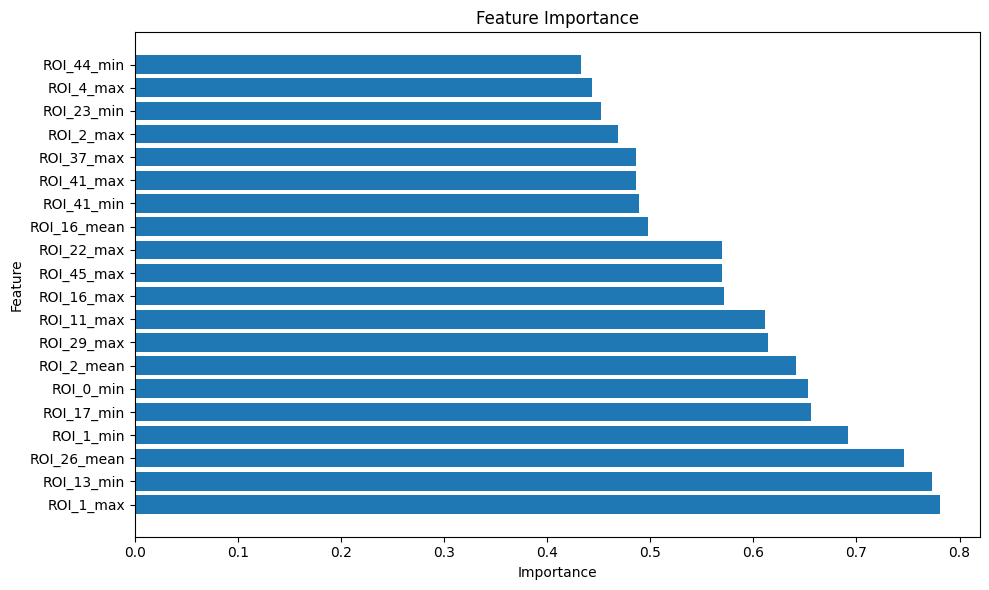

In [83]:
# Separation of feature names and their importance
features, importances = zip(*features_importance)

# Sorting features by importance
indices_sorted = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
top_indices = indices_sorted[:20]
sorted_features = [features[i] for i in top_indices]
sorted_importances = [importances[i] for i in top_indices]

# Creation of the graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [84]:
import pandas as pd
files_csv = ["C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-03.csv", "C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-05.csv", "C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-06.csv", "C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-07.csv", "C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/Lucas/Results/RegLog_classification/features_importance_sub-08.csv"]

# Load all files into a list of dataframes
dfs = [pd.read_csv(fichier) for fichier in files_csv]

# Combine all dataframes into one
df_total = pd.concat(dfs, ignore_index=True)


# Calculate the average of the 'Rank' column for each ROI
resultats_moyenne = df_total.groupby('Caractéristique')['Rank'].mean()

# Sort results by average rank to get a ranking
resultats_classement = resultats_moyenne.sort_values()

# Show ranking
resultats_classement.to_csv('features_ranking.csv')

In [85]:
df_total

,Caractéristique,Importance,Rank
0,ROI_18_min,0.929172,1
1,ROI_15_min,0.862606,2
2,ROI_24_min,0.843830,3
3,ROI_39_max,0.785687,4
4,ROI_41_max,0.726408,5
...,...,...,...
700,ROI_27_mean,0.023802,137
701,ROI_30_min,0.022812,138
702,ROI_46_min,0.021018,139
703,ROI_12_min,0.020040,140


Adding the features from the most important to the least important and plotting Accuracy : code for all subjects


In [4]:
#List of the subjects' numbers
subject_numbers = [3,5,6,7,8]

fmri_file_paths= {}
for i in subject_numbers:
    fmri_file_paths[f'fmri_file_paths_0{i}']= [f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-0{i}/func/sub-0{i}_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-0{i}/func/sub-0{i}_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
fmri_file_paths

{'fmri_file_paths_03': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-03/func/sub-03_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-03/func/sub-03_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'fmri_file_paths_05': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-05/func/sub-05_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-05/func/sub-05_task-carrsq_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'fmri_file_paths_06': ['C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/derivatives/sub-06/func/sub-06_task-carrsq_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'C:/Users/hennecol/Documents/FMRI experiment/

In [5]:
#List of the subjects' numbers
subject_numbers = [3,5,6,7,8]

# Load a brain atlas to define regions of interest (ROI)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# Initialization of a signal extractor using the atlas ROI map
masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

time_series ={}
for i in subject_numbers:
        # Extraction of average signals for each ROI from the two fMRI runs
    time_series_run1 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][0])
    time_series_run2 = masker.fit_transform(fmri_file_paths[f'fmri_file_paths_0{i}'][1])

    # Combination of time series from both runs
    # You can choose to concatenate them end to end or process them in another way depending on your analysis
    time_series_combined = np.concatenate([time_series_run1, time_series_run2], axis=0)
    time_series[f'time_series_combined_0{i}'] = time_series_combined


In [6]:
time_series

{'time_series_combined_03': array([[ 1.7590576 ,  1.3710945 ,  1.8598682 , ...,  2.4213545 ,
          1.7161274 ,  1.7505884 ],
        [ 1.3482339 ,  1.0176933 ,  1.1915458 , ...,  2.6588995 ,
          1.924127  ,  1.6181659 ],
        [ 0.7863176 ,  0.75171494,  0.61886656, ...,  2.45711   ,
          0.9758528 ,  1.1914631 ],
        ...,
        [ 0.25665647,  0.5507361 ,  0.18058947, ...,  0.6730461 ,
          1.0384507 ,  0.30812705],
        [ 0.27200353, -0.74588835,  0.20922397, ...,  0.39813316,
          1.720998  ,  0.8859683 ],
        [ 0.3657524 , -1.022482  , -0.196096  , ..., -0.09198082,
          1.2150891 ,  0.9309796 ]], dtype=float32),
 'time_series_combined_05': array([[ 2.248759  ,  1.5249485 ,  2.9237587 , ...,  2.2604232 ,
          0.17469081, -0.7355998 ],
        [ 1.279597  ,  0.59389555,  1.5463464 , ...,  2.0922356 ,
         -0.52565265, -1.8527327 ],
        [ 0.15887462,  0.22078523,  1.0116137 , ...,  1.3677198 ,
         -1.1470913 , -1.7770988 ]

In [7]:
def combine_events(num_sub):
    # Load events.tsv files
    events1 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{num_sub}/func/sub-0{num_sub}_task-carrsq_run-1_events.tsv', sep='\t')
    events2 = pd.read_csv(f'C:/Users/hennecol/Documents/FMRI experiment/FINAL FOLDER/BOLD_DATA/BIDS/sub-0{num_sub}/func/sub-0{num_sub}_task-carrsq_run-2_events.tsv', sep='\t')

    # Calculate the total time elapsed until the end of the first run
    # This is equal to the `onset` of the last event plus its `duration`
    total_time_elapsed = events1['onset'].iloc[-1] + events1['duration'].iloc[-1]

    # Add this total elapsed time to the `onset` of the second run
    events2['onset'] += total_time_elapsed


    # Concatenate files
    events_combined = pd.concat([events1, events2], ignore_index=True)
    
    return events_combined

In [8]:
events = {}
for i in subject_numbers:
    events[f'events_combined_0{i}'] = combine_events(i)
events

{'events_combined_03':     trial_type    onset  duration  nb_images
 0      control     0.00      7.00          7
 1      NonRisk     7.00     24.67         25
 2      control    31.67      8.00          8
 3      NonRisk    39.67     13.83         14
 4      control    53.50      8.00          8
 ..         ...      ...       ...        ...
 169    NonRisk  1503.79      5.40          5
 170       Risk  1509.19      2.70          3
 171    control  1511.89      8.00          8
 172    NonRisk  1519.89     12.63         13
 173    control  1532.52      8.00          8
 
 [174 rows x 4 columns],
 'events_combined_05':        onset  duration trial_type  nb_images
 0       0.00      7.00    control          7
 1       7.00     24.67    NonRisk         25
 2      31.67      8.00    control          8
 3      39.67     13.83    NonRisk         14
 4      53.50      8.00    control          8
 ..       ...       ...        ...        ...
 170  1503.79      5.40    NonRisk          5
 171  150

In [9]:
TR = 1  # Repeat time in seconds, adjust according to your data
delay_seconds = 6  # Time to see the effect of Risk stimulations
delay_points = delay_seconds / TR  # Number of data points corresponding to the delay


def create_df_roi_and_labels(num_sub):

    n_timestamps, n_rois = time_series[f'time_series_combined_0{num_sub}'].shape

    # Initialize a list to store the features extracted from each segment for each ROI
    features_per_roi = {roi: [] for roi in range(n_rois)}  # A dictionary for each ROI

    # Initializing the list to store features and labels
    labels = []

    # Go through each segment to extract features
    for _, row in events[f'events_combined_0{num_sub}'].iterrows():
        onset_time = row['onset']
        duration = row['duration']
        trial_type = row['trial_type']

        # if trial_type == 'Risk':
        #     adjusted_onset_time = onset_time + delay_seconds
        # else:
        #     adjusted_onset_time = onset_time
        adjusted_onset_time = onset_time + delay_seconds

        #adjusted_onset_time = onset_time
        start_index = int(adjusted_onset_time / TR)  # Convert onset to data point index
        end_index = start_index + int(row['nb_images'])  # Determine the end index of the segment
        
        

        for roi in range(n_rois):
        # Extract segment from time series
            segment = time_series[f'time_series_combined_0{num_sub}'][start_index:end_index,roi]

            # # Calculation of wavelet coefficients
            # coeffs = pywt.wavedec(segment, 'db1', level=2)
            # wavelet_features = [np.mean(coef) for coef in coeffs]  # Moyenne des coefficients à chaque niveau
            # energy = [np.sum(coef ** 2) for coef in coeffs]  # Énergie des coefficients à chaque niveau

            
            # Calculate the desired characteristics for the segment
            segment_features = [
                np.mean(segment),  # Average
                #np.std(segment),   # Standard deviation
                np.min(segment),   # Minimum
                np.max(segment),   # Maximum
                #len(np.where(np.diff(np.sign(segment)))[0]) #zero-crossing
                #segment.max() - segment.min() #peak-to-peak
                #np.sum(segment ** 2), #Energy
                #skew(segment),     #Asymetrie: returns Nan because some segments have a low number of timestamps (<3)
            ] #+ wavelet_features  # Added wavelet features

            features_per_roi[roi].append(segment_features)  # Add the characteristic to the list for this ROI
        
            # Add segment characteristics and label to lists
        labels.append(row['trial_type'])

    # Convert lists to numpy arrays for later analysis
    labels = np.array(labels)
    df_roi = pd.DataFrame(features_per_roi)

    return labels, df_roi

In [19]:
def create_filtered_features_labels(df,labels):
    # Transform df into a format where each feature is a column
    data = []
    for _, row in df.iterrows():
        row_data = []
        for col in df.columns:
            # Expand the list of characteristics in the columns
            row_data.extend(row[col])
        data.append(row_data)

    #wavelet_feats = ['wavelet_mean_level1', 'wavelet_mean_level2', 'wavelet_mean_level3']
    # Adjust the list of features to include those extracted from the wavelet coefficients
    features = ['mean', 'min', 'max'] #+ wavelet_feats


    # Create a new DataFrame with the transformed data
    columns = [f'ROI_{i}_{feat}' for i in range(len(df.columns)) for feat in features]
    df_features = pd.DataFrame(data, columns=columns)

    # Filter to keep only Risk and NonRisk
    mask = (labels == 'Risk') | (labels == 'NonRisk')
    filtered_features = df_features[mask]
    filtered_labels = labels[mask]

    #Creates a mask to remove half of the data labelled as "NonRisk" to have a more balanced dataset
    non_risk_indices = np.where(filtered_labels == 'NonRisk')[0]
    np.random.shuffle(non_risk_indices)
    half_non_risk_indices = non_risk_indices[:len(non_risk_indices) // 2]
    mask2 = np.ones(len(filtered_labels), dtype=bool)
    mask2[half_non_risk_indices] = False
    filtered_features = filtered_features[mask2]
    filtered_labels = filtered_labels[mask2]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(filtered_labels)

    return filtered_features, y_encoded
    


In [20]:
dict_df = {}
for i in subject_numbers:
    labels, df = create_df_roi_and_labels(i)
    filtered_df, y = create_filtered_features_labels(df,labels)
    dict_df[f'sub_0{i}'] = [filtered_df,y]

In [30]:
from sklearn.model_selection import cross_val_score, KFold
# model = LogisticRegression(max_iter=1000)

# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(random_state=42)

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(random_state=42)

# from sklearn.svm import SVC
# model = SVC(kernel='rbf')

# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=5)

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(random_state=42, hidden_layer_sizes=(65,), max_iter=500)

# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(random_state=42)

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

# from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(random_state=42)

def mean_accuracy(df):
    # Configuration de la validation croisée K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 Folds

    accuracy_list = [] #List to store the calculated accuracy of the subjects
    score_list = []
    for i in subject_numbers:
    # Réalisation de la validation croisée
        scores = cross_val_score(model, df[f'sub_0{i}'][0], df[f'sub_0{i}'][1], cv=kf, scoring='accuracy')
        score_list.append(scores)
        accuracy_sub = np.mean(scores)
        accuracy_list.append(accuracy_sub)

    return np.std(accuracy_list), np.mean(accuracy_list)

mean_accuracy(dict_df)

(0.060334363328880286, 0.7046739926739927)

In [181]:
#Check the output of the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


def get_metrics(i):
    '''
    i : subject number (in [3,5,6,7,8])
    '''

    X_train, X_test, y_train, y_test = train_test_split(dict_df[f'sub_0{i}'][0], dict_df[f'sub_0{i}'][1], test_size=0.2, random_state=42)

    # Training your model
    model.fit(X_train, y_train)

    unique, count = np.unique(y_train, return_counts=True)
    dictio = dict(zip(unique, count))
    print("training dataset distribution", dictio)

    # Prédictions
    y_pred = model.predict(X_test)

    # Calculation of the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion:\n", cm)

    # Extract TP, FP, TN, FN
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Calculation of false positive rate (FPR) and false negative rate (FNR)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    # Accuracy calculation
    accuracy = accuracy_score(y_test, y_pred)

    # Calculation of F1 score
    f1 = f1_score(y_test, y_pred)  # Make sure this is suitable if you have a multiclass classification

    # Display
    print(y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Taux de faux positifs (FPR): {FPR:.3f}")
    print(f"Taux de faux négatifs (FNR): {FNR:.3f}")

In [186]:
get_metrics(8)

training dataset distribution {0: 55, 1: 31}
Matrice de confusion:
 [[13  2]
 [ 3  4]]
[1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
Accuracy: 0.773
F1 Score: 0.615
Taux de faux positifs (FPR): 0.133
Taux de faux négatifs (FNR): 0.429


In [162]:
dict_df['sub_03'][0]

,ROI_0_mean,ROI_0_min,ROI_0_max,ROI_1_mean,ROI_1_min,ROI_1_max,ROI_2_mean,ROI_2_min,ROI_2_max,ROI_3_mean,...,ROI_43_max,ROI_44_mean,ROI_44_min,ROI_44_max,ROI_45_mean,ROI_45_min,ROI_45_max,ROI_46_mean,ROI_46_min,ROI_46_max
1,1.071326,0.722429,1.351293,1.192971,0.420645,1.898181,1.528543,0.854805,2.737183,0.463420,...,1.771254,0.955302,-0.398498,2.179569,0.411123,-0.950031,1.930695,-2.100555,-2.906874,-1.033741
3,1.340221,1.108776,1.598650,1.273729,0.577347,2.143938,1.363104,0.675004,2.414553,0.459974,...,1.822083,0.701708,-0.340535,2.348416,0.184386,-1.159980,1.532221,-1.610780,-2.153435,-0.569819
5,1.611762,1.588575,1.636225,1.675830,1.134795,2.133662,1.853136,1.496589,2.081811,1.046337,...,1.731429,1.549543,1.320213,1.791473,0.681000,0.325372,1.028058,-1.337210,-1.403485,-1.250006
6,1.277919,1.173629,1.334926,1.428361,1.169475,1.680254,1.110444,0.607065,1.372720,0.115385,...,1.489859,1.221929,0.934637,1.496621,0.422968,0.141132,0.618158,-1.694163,-2.184828,-1.169779
8,1.159213,1.011584,1.280016,1.152502,0.445478,2.128953,1.209802,0.163409,2.292895,0.487938,...,1.682696,0.610084,-0.345576,1.229490,0.161637,-0.875763,1.516511,-1.315284,-1.902289,-0.325649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-0.552733,-0.884125,-0.187010,-0.321449,-0.908356,0.086948,-0.262379,-0.884275,0.344242,-0.688556,...,1.499661,-1.228993,-1.309217,-1.116177,-0.629206,-1.078160,-0.195598,-0.489883,-0.928777,-0.021262
167,-0.758106,-1.727995,0.696041,-0.676090,-2.991268,0.845400,-0.443754,-1.925087,0.989479,-1.111374,...,2.964173,-1.731732,-3.843806,-0.025627,-0.762139,-2.602586,1.132849,-0.381820,-2.182511,1.326895
169,-1.287684,-2.092190,-0.341670,-0.891986,-2.555877,0.659052,-0.949899,-1.815836,-0.310894,-1.403683,...,0.657042,-1.085592,-2.808410,0.062119,-0.997664,-2.356626,0.402861,0.479182,-0.823862,1.400336
170,-0.906732,-1.156441,-0.705178,-0.067761,-0.088079,-0.047152,-1.182942,-1.426494,-0.802521,-1.768147,...,0.958353,-0.461011,-0.872997,0.225074,-0.667788,-0.821678,-0.542835,-0.042245,-0.535346,0.419381


In [117]:
features_ordered = resultats_classement.index.to_list()
features_ordered

['ROI_4_max',
 'ROI_35_max',
 'ROI_15_min',
 'ROI_14_max',
 'ROI_25_max',
 'ROI_38_min',
 'ROI_13_min',
 'ROI_23_min',
 'ROI_16_max',
 'ROI_45_max',
 'ROI_36_min',
 'ROI_41_max',
 'ROI_8_max',
 'ROI_4_mean',
 'ROI_9_min',
 'ROI_2_mean',
 'ROI_23_max',
 'ROI_10_max',
 'ROI_0_min',
 'ROI_2_min',
 'ROI_44_min',
 'ROI_36_mean',
 'ROI_37_min',
 'ROI_29_max',
 'ROI_3_mean',
 'ROI_46_mean',
 'ROI_26_mean',
 'ROI_42_mean',
 'ROI_39_min',
 'ROI_1_min',
 'ROI_34_min',
 'ROI_39_max',
 'ROI_31_mean',
 'ROI_40_max',
 'ROI_34_max',
 'ROI_39_mean',
 'ROI_31_min',
 'ROI_40_min',
 'ROI_43_mean',
 'ROI_23_mean',
 'ROI_22_mean',
 'ROI_44_max',
 'ROI_11_min',
 'ROI_24_min',
 'ROI_9_max',
 'ROI_10_min',
 'ROI_10_mean',
 'ROI_7_max',
 'ROI_36_max',
 'ROI_29_min',
 'ROI_11_max',
 'ROI_25_min',
 'ROI_32_max',
 'ROI_28_max',
 'ROI_22_max',
 'ROI_26_min',
 'ROI_2_max',
 'ROI_46_max',
 'ROI_20_mean',
 'ROI_46_min',
 'ROI_38_max',
 'ROI_5_mean',
 'ROI_30_min',
 'ROI_5_min',
 'ROI_29_mean',
 'ROI_0_max',
 'ROI_3_m

In [118]:
import copy
accuracies = []
features_used = []
std_list = []

for i in range(len(features_ordered)):
    features_to_use = features_ordered[:i+1]
    features_used.append(features_to_use[-1]) # Adds the name of the last added feature
    dict_filtered = copy.deepcopy(dict_df)
    for sub in dict_filtered.values():
        sub[0] = sub[0][features_to_use]

    result = mean_accuracy(dict_filtered)
    accuracies.append(result[1])
    std_list.append(result[0])
    


In [119]:
accuracies, std_list

([0.4954652014652014,
  0.5147252747252746,
  0.5619267399267399,
  0.5737289377289377,
  0.6175750915750916,
  0.6124029304029304,
  0.6244908424908425,
  0.6711135531135531,
  0.6684468864468865,
  0.6853919413919414,
  0.6785347985347985,
  0.6856336996336997,
  0.6853479853479854,
  0.6881391941391941,
  0.6911501831501832,
  0.6935311355311355,
  0.7036630036630036,
  0.7099120879120878,
  0.7065787545787545,
  0.7049890109890109,
  0.7011794871794871,
  0.6986080586080586,
  0.7019120879120878,
  0.6996556776556776,
  0.7085128205128204,
  0.7021391941391941,
  0.6996849816849816,
  0.7065054945054946,
  0.7008278388278388,
  0.7037875457875458,
  0.7003882783882786,
  0.7151721611721612,
  0.7206666666666667,
  0.716886446886447,
  0.722857142857143,
  0.722857142857143,
  0.7171135531135532,
  0.7237802197802198,
  0.7207032967032967,
  0.7121318681318682,
  0.7183223443223443,
  0.7178461538461539,
  0.7117216117216119,
  0.7143223443223444,
  0.7211428571428572,
  0.720666666

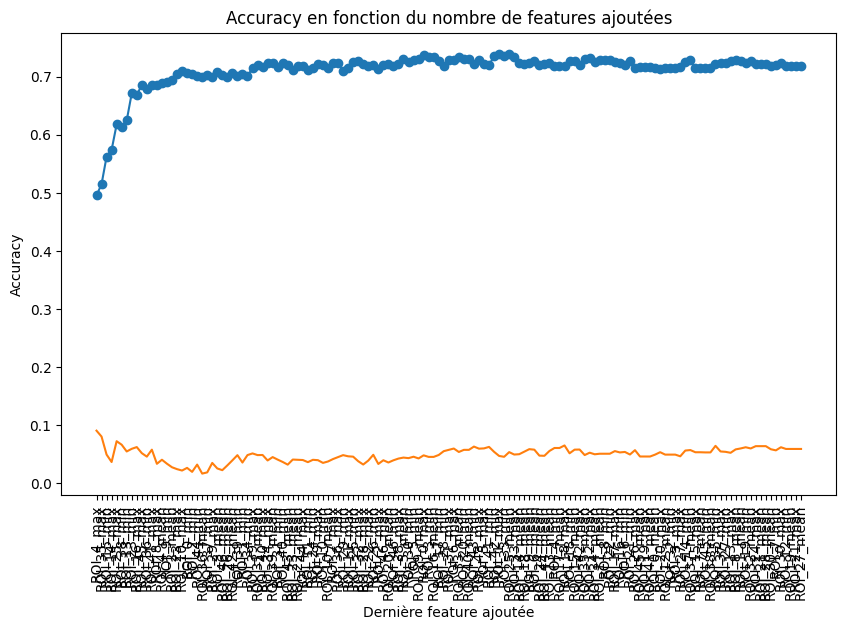

In [120]:
# Plot accuracy versus number of features
plt.figure(figsize=(10, 6))
plt.plot(features_used, accuracies, marker='o')
plt.plot(features_used, std_list)
plt.xlabel('Dernière feature ajoutée')
plt.ylabel('Accuracy')
plt.xticks(rotation=90) # To improve the readability of labels on the x axis
plt.title('Accuracy en fonction du nombre de features ajoutées')
plt.show()

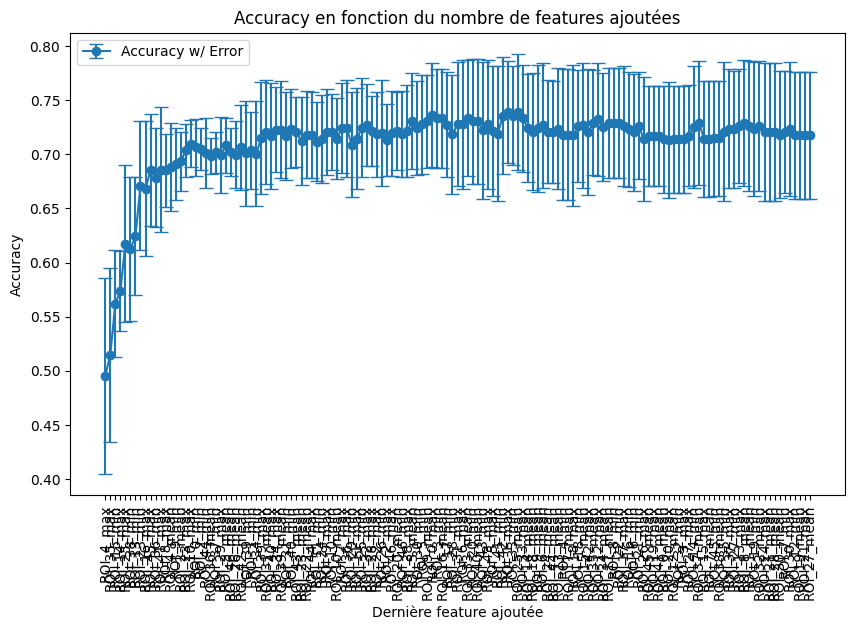

In [121]:
plt.figure(figsize=(10, 6))

# Use errorbar instead of plot for accuracies with error bars
plt.errorbar(features_used, accuracies, yerr=std_list, label='Accuracy w/ Error', marker='o', capsize=5)

plt.xlabel('Dernière feature ajoutée')
plt.ylabel('Accuracy')
plt.xticks(features_used, rotation=90) # Assuming features_used is a list of feature counts
plt.title('Accuracy en fonction du nombre de features ajoutées')

# Option to add a legend if you want to label the error bars plot
plt.legend()

plt.show()

In [122]:
from scipy.signal import find_peaks

# Find the indices of local maxima
peaks_indices, _ = find_peaks(accuracies)

# Retrieve the names of the features corresponding to the local maxima
peaks_features = [features_used[i] for i in peaks_indices]

print(peaks_indices)


[  4   7   9  11  17  22  24  27  29  32  34  37  40  44  47  52  55  58
  61  65  70  72  76  80  82  87  90  95  98 101 106 109 118 124 127 130
 136]


In [123]:
accuracies.index(max(accuracies))

82

In [124]:
max(accuracies)

0.7395531135531136

Train a single model on the 5 subjects. Leave One Out Method

c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


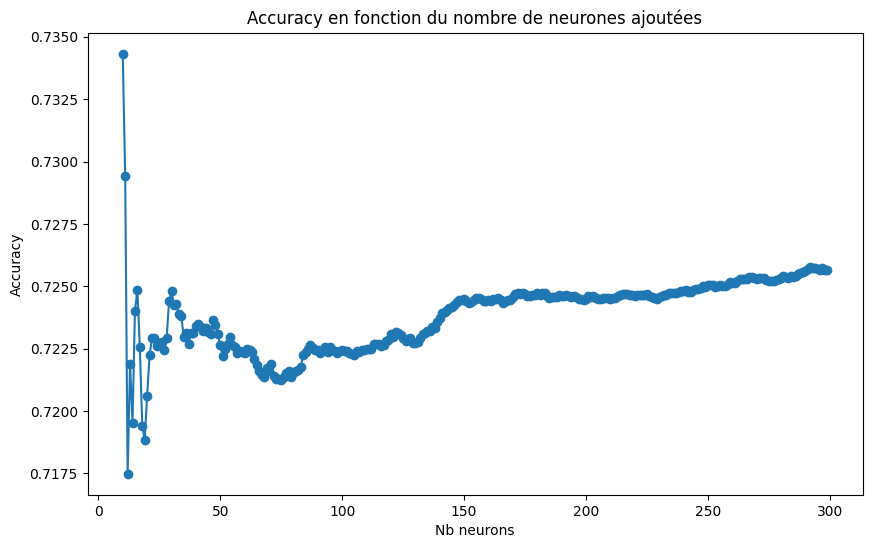

In [41]:
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


#Here with MLP, try to find the optimized number of neurons

loo = LeaveOneOut()
scores = []

# Concatenate all data into a single matrix
X_total = np.concatenate([dict_df[sub][0] for sub in dict_df], axis=0)
y_total = np.concatenate([dict_df[sub][1] for sub in dict_df], axis=0)

# Index to track topic datasets
indices = np.concatenate([[i] * len(dict_df[sub][1]) for i, sub in enumerate(dict_df)])

nb_neurons = []
accuracies_neurons = []
for i in range (10,300):
# Leave-One-Out cross-validation loop on topics
    for train_subs, test_sub in loo.split(dict_df):
        # Selection of training and testing data based on topics
        X_train, X_test = X_total[indices != test_sub], X_total[indices == test_sub]
        y_train, y_test = y_total[indices != test_sub], y_total[indices == test_sub]
        
        # Model creation and training
        model = MLPClassifier(random_state=42, hidden_layer_sizes=(i,), max_iter=1000)
        model.fit(X_train, y_train)
        
        # Prediction and evaluation
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions)
        scores.append(score)

    # Calculation of average accuracy on all subjects
    accuracy_moyenne = np.mean(scores)
    #print(f"Accuracy moyenne en LOO sur les sujets : {accuracy_moyenne}")
    nb_neurons.append(i)
    accuracies_neurons.append(accuracy_moyenne)

plt.figure(figsize=(10, 6))
plt.plot(nb_neurons, accuracies_neurons, marker='o')
plt.xlabel('Nb neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction du nombre de neurones ajoutées')
plt.show()


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb



#Here with other classifiers

loo = LeaveOneOut()
scores = []

# Concatenate all data into a single matrix
X_total = np.concatenate([dict_df[sub][0] for sub in dict_df], axis=0)
y_total = np.concatenate([dict_df[sub][1] for sub in dict_df], axis=0)

# Index to track topic datasets
indices = np.concatenate([[i] * len(dict_df[sub][1]) for i, sub in enumerate(dict_df)])

nb_neurons = []
accuracies_neurons = []

# Leave-One-Out cross-validation loop on topics
for train_subs, test_sub in loo.split(dict_df):
    # Selection of training and testing data based on topics
    X_train, X_test = X_total[indices != test_sub], X_total[indices == test_sub]
    y_train, y_test = y_total[indices != test_sub], y_total[indices == test_sub]
    
    # Model creation and training
    model = AdaBoostClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Prediction and evaluation
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    scores.append(score)

# Calculation of average accuracy on all subjects
accuracy_moyenne = np.mean(scores)
print(f"Accuracy moyenne en LOO sur les sujets : {accuracy_moyenne}")




c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documents\FMRI experiment\FINAL FOLDER\Lucas\virtual_environnement\carrs-q_projectv2\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hennecol\Documen

Accuracy moyenne en LOO sur les sujets : 0.7017783099159154


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
import numpy as np

loo = LeaveOneOut()

def compute_accuracy_xgboost(dataframe):
    scores = []

    # Concatenate all data into a single matrix
    X_total = np.concatenate([dataframe[sub][0] for sub in dataframe], axis=0)
    y_total = np.concatenate([dataframe[sub][1] for sub in dataframe], axis=0)

    # Index to track topic datasets
    indices = np.concatenate([[i] * len(dataframe[sub][1]) for i, sub in enumerate(dataframe)])

    # Configuring settings for XGBoost
    params = {
        'max_depth': 3,
        'eta': 0.1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }
    num_rounds = 100

    # Leave-One-Out cross-validation loop on topics
    for train_subs, test_sub in loo.split(dataframe):
        # Selection of training and testing data based on topics
        X_train, X_test = X_total[indices != test_sub], X_total[indices == test_sub]
        y_train, y_test = y_total[indices != test_sub], y_total[indices == test_sub]
        
        # Converting training and test sets to DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # XGBoost model training
        bst = xgb.train(params, dtrain, num_rounds)
        
        # Prediction and evaluation
        predictions = bst.predict(dtest)
        # Convert probabilities to binary classes using 0.5 as threshold
        predictions_binary = (predictions > 0.5).astype(int)
        score = accuracy_score(y_test, predictions_binary)
        scores.append(score)

    # Calculation of average accuracy on all subjects
    accuracy_moyenne = np.mean(scores)

    return accuracy_moyenne


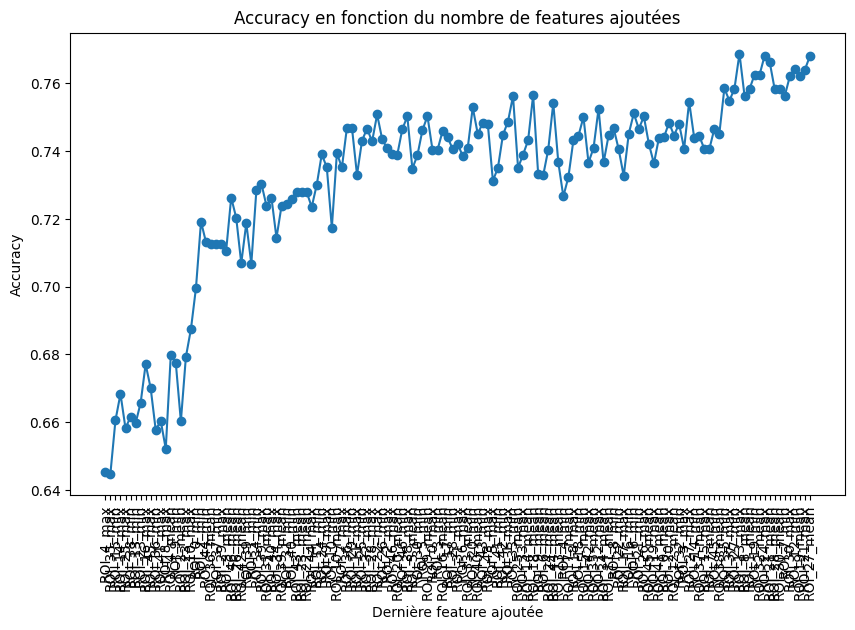

In [ ]:
import copy
accuracies = []
features_used = []

for i in range(len(features_ordered)):
    features_to_use = features_ordered[:i+1]
    features_used.append(features_to_use[-1]) # Adds the name of the last added feature
    dict_filtered = copy.deepcopy(dict_df)
    for sub in dict_filtered.values():
        sub[0] = sub[0][features_to_use]

    accuracy = compute_accuracy_xgboost(dict_filtered)
    accuracies.append(accuracy)


# Plot accuracy versus number of features
plt.figure(figsize=(10, 6))
plt.plot(features_used, accuracies, marker='o')
plt.xlabel('Dernière feature ajoutée')
plt.ylabel('Accuracy')
plt.xticks(rotation=90) # To improve the readability of labels on the x axis
plt.title('Accuracy en fonction du nombre de features ajoutées')
plt.show()